==============================================================================================
# Practicum 6 - Part 1

==============================================================================================

## Delivery

Up to **1 point out of 10** will be penalized if the following requirements are not fulfilled:

- Implemented code should be commented.

- The questions introduced in the exercises must be answered.

- Add title to the figures to explain what is displayed.

- Comments need to be in **english**.

- The deliverable must be a file named **P6_Student1_Student2.zip** that includes:
    - The notebook P6_Student1_Student2.ipynb completed with the solutions to the exercises and their corresponding comments.
    - All the images used in this notebook.

**Deadline (Group A- Group F): December 10th, 23:00 h**

**Deadline (Group B): December 11th, 23:00 h**

==============================================================================================
## Haar-like features applied for face detection
==============================================================================================

Today's exercices will practise the following:

- Integral images and a classical use for fast harr-like feature computation.
- Use of Adaboost for classification.
- Decisions based on a user-defined threshold for balancing precision and recall.

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage.color import rgb2gray
from skimage import io
from time import time

import skimage
from skimage.feature import haar_like_feature
from skimage.transform import resize
from skimage.feature import haar_like_feature_coord
from skimage.feature import draw_haar_like_feature
from sklearn.model_selection import train_test_split

/home/pau/.local/lib/python3.8/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [2]:
def visualize_n(image_list):

    fig=plt.figure(figsize=(15,15))
    for i in range(len(image_list)):
        
        fig.add_subplot(1,len(image_list),i +1)
        plt.imshow(image_list[i], cmap='gray')
        plt.xticks([])
        plt.yticks([])
        
def visualize_n_w_labels(image_list, labels):

    fig=plt.figure(figsize=(15,15))
    for i in range(len(image_list)):
        
        fig.add_subplot(1,len(image_list),i +1)
        plt.imshow(image_list[i], cmap='gray')
        plt.title(labels[i])
        plt.xticks([])
        plt.yticks([])
        
def normalize(image): return (image[:,:]- image.min())/(image.max() - image.min())


## Haar-like feature descriptor for face detection

### What is a Haar-like feature?

Haar-like features are features extracted from the images to recognize objects. These features are normally used in face recognition. The key to face recognition is to detect the relevant features of humans such as eyes, lips, or nose. 


<img src="notebook_images/haar-like.PNG" width=400, height=400>

Try to guess where in the face image we expect to detect an edge, line or another facial feature and what would be the most appropriate Haar-feature for them? 

<img src="notebook_images/haar-like1.PNG" width=500, height=500>


A real application would be:

<img src="notebook_images/face.PNG" width=300, height=300>


To describe the face, we can apply convolutions with Haar features. What alternative to the convolution with Haar-features, do you know?


### Face detection

Haar-like feature descriptors were successfully used to implement the first real-time face detector. In this laboratory we will see an example illustrating the extraction, selection, and classification of Haar-like features to detect faces vs. non-faces.

Documentation [Haar-like feature skimage](https://scikit-image.org/docs/0.14.x/auto_examples/xx_applications/plot_haar_extraction_selection_classification.html)


In this work we are going to see:


1. What is a Haar-like feature?
2. Build Integral image
3. Extract Haar features
4. The Adaboost Classifier
5. Face detection with cascade classifier

### 1. Building integral image

Compute all the Haar-like features (we can define up to 16000 million masks), can be a slow process. To compute it faster, we are going to use the integral images (instead of convolutions). It is very useful because we are able to save all the sums and substrations of image rectangles to avoid computing all the features every time.

When creating an Integral Image, we need to create a Summed Area Table. What does represent any point (x,y) in this table?

<img src="notebook_images/integral_image.PNG" width=250, height=2500>

An example :

<img src="notebook_images/integral_image1.PNG" width=400, height=400>

To easy the computation of Haar features, the integral image must have an additional row and column full of zeros (first row and first column). Why?

**1.1** Build a function `to_integral_image` that computes the integral image of an input (2D) array.

The integral image must have an additional row and column full of zeros (first row and first column).
Make sure that the values of the integral image are correct.

In [3]:
def to_integral_image(img_arr):
    row_sum = np.zeros(img_arr.shape)
    integral_image_arr = np.zeros((img_arr.shape[0] + 1, img_arr.shape[1] + 1)).astype(int)

    for x in range(1, integral_image_arr.shape[0]):
        for y in range(1, integral_image_arr.shape[1]):
            integral_image_arr[x, y] = img_arr[x-1][y-1] + integral_image_arr[x][y-1] + integral_image_arr[x-1][y] - integral_image_arr[x-1][y-1]   
    
    return integral_image_arr

**1.2** Construct a binary image of dimensiones 5x5 and visualize it together with its integral image.

In [4]:
img_array = np.random.randint(2, size=(5,5))
ii_img_array = to_integral_image( img_array )

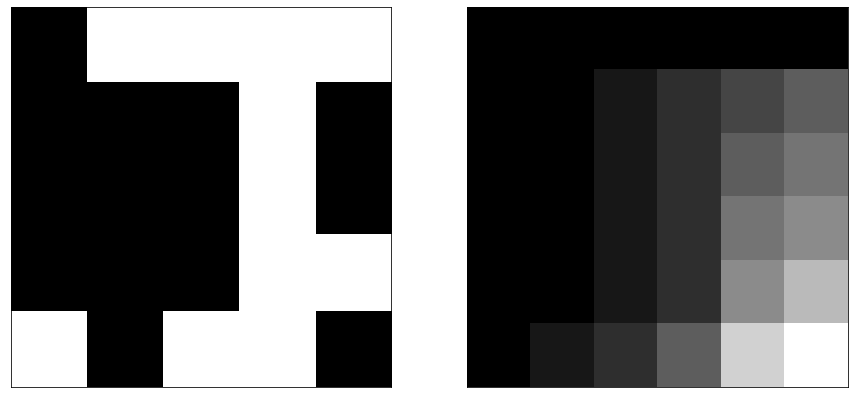

In [5]:
visualize_n([img_array, ii_img_array])

**1.3** Integral image test

To make sure that the values of the integral image are correct, compute the following tests:

 - `sum(img_array) == ii_img_array[-1,-1]`
 - `img_array[0,:].sum() == ii_img_array[1,-1]`

In [6]:
np.sum(img_array) == ii_img_array[-1,-1]

True

In [7]:
img_array[0,:].sum() == ii_img_array[1,-1]

True

**1.4** Let's check in real images.

Choose an image from the directory ``./faces``, visualize both the original and the integral image, and make the same test that in the previous question.

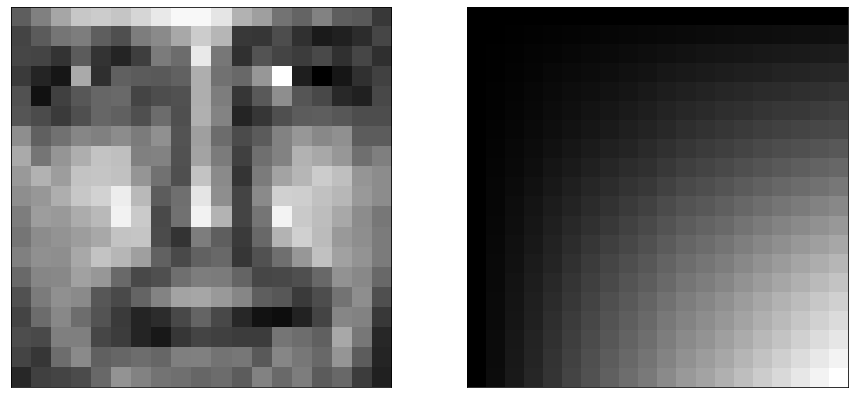

In [8]:
face = io.imread("faces/face00001.png")
visualize_n([face, to_integral_image(face)])

**1.5** What do the following lines mean? How can you explain this?

 - `sum(img_array) == ii_img_array[-1,-1]`
 - `img_array[0,:].sum() == ii_img_array[1,-1]`
 - `ii_img_array[0,-1].sum() == 0`
 


In [9]:
np.sum(img_array) == ii_img_array[-1,-1]

True

**Explanation**:
The array[-1] returns us the last element of the list

In [10]:
llista = [i for i in range(0,10)]
llista[-1] == llista[9]

True

Therefore, ii_img_array[-1,-1] returns us the value of the last pixel of the integral image of img_array. That is the same to say that that pixel is the area of all the picture, which is the same as adding all the pixels of the image img_array, which is the first part. That is why is true

In [11]:
img_array[0,:].sum() == ii_img_array[1,-1]

True

**Explanation**:
img_array[0,:] gives us an array of the first column on the image, and sum() adds all the values of the colum, and the second part gives us the area of the first column, which is adding all the elements above, which are:
* The first column filled with zeroes
* The second column, which is the same as the first of img_array

Therefore, the values are equal.

In [12]:
ii_img_array[0,-1].sum() == 0

True

**Explanation**: equally as the last question, ii_img_array[0,-1] returns the value of the last element of the first column of the integral image of the image. This element is 0 because we have added a first column filled with 0 to calulate the integral image more easily. As all the elements in this column, the sum of all of them is 0. The result also yelds True if you don't add all the values.

In [13]:
ii_img_array[0,-1] == 0

True

**1.6: (Optional)** Alternatively to your own function, you can use the function of skimage ``skimage.transform import integral_image``. 

Compare the result obtained using your funtion and that obtained using the function provided by skimage.

True

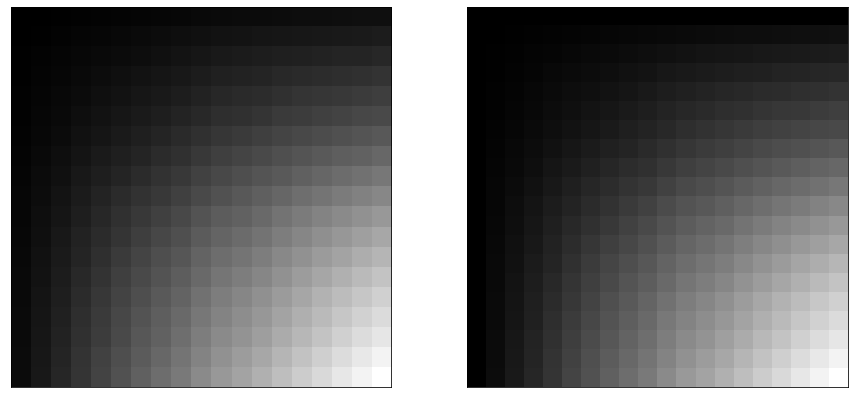

In [15]:
from skimage.transform import integral_image
visualize_n([integral_image(face), to_integral_image(face)])
#if the sum of all pixels is the same, it's probably doing it fine
np.sum(integral_image(face)) == np.sum(to_integral_image(face))

## 2. Haar-like features

Let's use the haar_like_feature function from skimage [Haar like feature](https://scikit-image.org/docs/0.14.x/api/skimage.feature.html#skimage.feature.haar_like_feature)

*skimage.feature.haar_like_feature(int_image, rint, cint, widthint, heightint, feature_type=None, feature_coord=None)*

Check the parameters and the returned value of the ``function haar_like_feature()`` before continuing.

###  Extract features

**2.1** Once we have the function to get the integral image, we can extract the features before building the classifier.

Define a function ``extract_feature_image`` to obtain the Haar-like features, using a given type of features ``feature_types``, from an image.


In [17]:
feature_types = ['type-2-x', 'type-2-y',
                 'type-3-x', 'type-3-y',
                 'type-4']

In [18]:
def extract_feature_image(image, feature_type, feature_coord=None):
    int_image = integral_image(image)
    return haar_like_feature(int_image, 0,0, image.shape[0], image.shape[1], feature_type=feature_type, feature_coord=feature_coord)


Try your function using the choosing image from *1.4*. 

**Note:** You have to obtain a feature vector. Print the vector shape.

In [19]:
features = extract_feature_image(face, feature_types)
len(features)

63666

**2.2** Plot a Haar-like feature on an image:

To visualize Haar-like features on an image, we need the fuctions, provided by skimage, ``haar_like_feature_coord()``, which computes the coordinates of Haar-like features, and ``draw_haar_like_feature()``, used to visualize that features.

Before continuing, please, **check the online documentation of the two functions**

- *skimage.feature.haar_like_feature_coord(width, height, feature_type=None)*

- *skimage.feature.draw_haar_like_feature(image, r, c, width, height, feature_coord, color_positive_block=(1.0, 0.0, 0.0), color_negative_block=(0.0, 1.0, 0.0), alpha=0.5, max_n_features=None, random_state=None)*


Define a function ``plotFeatures``  to visualize Haar-like features on an images, given a array of feature types ``feature_types``.

In [20]:
def plotFeatures(image, num_images=10):

    images = []
    coord, _ = haar_like_feature_coord(image.shape[0], image.shape[1], feature_type=feature_types)
    
    for c in coord[:num_images]:
        images.append(draw_haar_like_feature(image, 0,0, image.shape[0], image.shape[1], [c]))
        
    visualize_n(images)

Try your function using the choosing image from *1.4* as follows:
<img src="notebook_images/image1.png" width=600, height=300>

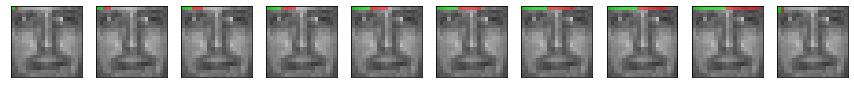

In [21]:
plotFeatures(face)

### 3 Preparing the Dataset

**3.1** Read all the images from the directories ``./faces`` and ``./nonfaces`` and build an array with the all the features. 

Futhermore, build the class labels vector ``y`` with the label of all the images

In [22]:
LABELS = {
    1 : "FACE",
    0 : "NO FACE"
}

In [23]:
# Build a vector with the faces features
path = "./faces/"                       
face_images = [skimage.io.imread(path + f) for f in os.listdir(path)]

features_faces = [extract_feature_image(i, feature_types) for i in face_images]

In [24]:
# Build a vector with the non-faces features
path = "./nonfaces/"                       
non_face_images = [skimage.io.imread(path + f) for f in os.listdir(path)]

non_features_faces = [extract_feature_image(i, feature_types) for i in non_face_images]



In [25]:
X = np.array(features_faces + non_features_faces)
y = np.concatenate((np.ones(len(features_faces)) , np.zeros(len(non_features_faces)))) # Labels face = 1, non face = 0

**3.2** Using the function ``train_test_split`` from sklearn, divide the dataset into *train* and *test* set

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

### 4  Adaboost training

**4.1** Train an Adaboost classifier using:

*class sklearn.ensemble.AdaBoostClassifier(n_estimators=50, learning_rate=1.0)*

What is an Adaboost doing?

In [27]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(n_estimators=50, learning_rate=1.0)
ada.fit(X_train, y_train)

AdaBoostClassifier()

AdaBoost (short for adapative boosting) is an statistical classification meta-algorithm formulated by Yoav Freund and Robert Schapire.

The AdaBoost, speciflicly, is a particular method of training a boosted classifier using the next formula:

$ E_t = \sum_i{E[F_{t-1}(x_i)+\alpha_ih(x_i)]}$

Where $E_t$ is the sum of training error, $h(x)$ is our hypotesis for each sample in the training set and $\alpha_t$ is assinged such as the sum of training error is mimimized. $F_{t-1}$ is the already said booster classifier, $E[F]$ is some error funcion and $\alpha_ih(x_i)$ is the weak learner for the final classifier.

The diference is in the weighting; at the beginning of each iteration a weight is assignet to sample each training set to equal the correct error on the sample to inform the training of the weak learners which can lead into splitting sets of samples with different weights.

Summary: is training the model using weights at each iteration to optimize the results.

Reference: https://en.wikipedia.org/wiki/AdaBoost

**4.2** Evaluate the accuracy of the Adaboost classifier using the *predict* and *score* methods of the classifier. What are these methods doing?

In [28]:
ada.score(X_test, y_test)

0.9411764705882353

In [29]:
result = np.array([ada.predict(image.reshape(1,-1)) for image in X_test]).flatten()

result == y_test

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True])

predict() returns the class of the image. In our case, 0 is not a face and 1 is a face.
score() return how good is the guess. As nearer to one it is, the better guess it is.

Obviously, the score of X_test and y_test is gonna have a high score and one and almost a perfect prediction, because is the set we have trained.

Change the parameter ``n_estimators`` and see what happens. Does it improve?

In [30]:
ada2 = AdaBoostClassifier(n_estimators=100)
ada2.fit(X_train, y_train)
ada2.score(X_test, y_test)

0.9411764705882353

In [31]:
ada2 = AdaBoostClassifier(n_estimators=10)
ada2.fit(X_train, y_train)
ada2.score(X_test, y_test)

0.9411764705882353

Theoretically, as higher the number of estimators goes, the better is the prediction, but, due to the smallness of the training sample (and the model) sometimes is the same result, but never worse if the number of estmators is larger.

**4.3** The method ``feature_importances_`` of the Adaboost is giving the importance of the features. Implement a function to visualize the 10 most important features on an image of a face on your choice. 

In [32]:
num_features = 10
image = face_images[11]
coord, _ = haar_like_feature_coord(image.shape[0], image.shape[1], feature_type=feature_types)

importances = ada2.feature_importances_
sorted_importances_index = np.argsort(importances)[::-1] #Reverse as its sorted ASC
    
result = []
for idx in sorted_importances_index[:num_features]:
    result.append(draw_haar_like_feature(image, 0, 0, image.shape[0], image.shape[1], [coord[idx]]))

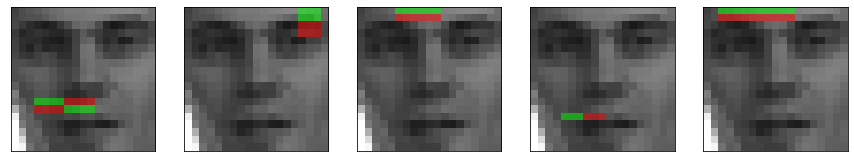

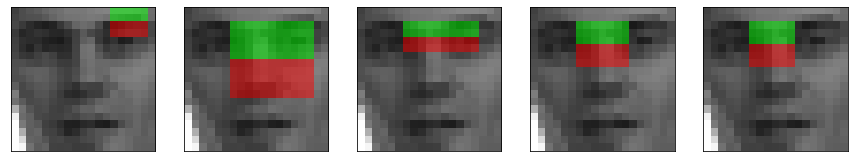

In [33]:
visualize_n(result[:5])
visualize_n(result[5:10])

**4.4**  Try the Adabost classifier using other faces and non-faces images. What is the result? 

<ipython-input-34-0963684767eb>:5: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  face = rgb2gray(resize(io.imread("more_faces/face.png"), (19, 19)))
<ipython-input-34-0963684767eb>:6: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  no_face = rgb2gray(resize(io.imread("more_faces/no_face.png") ,(19, 19)))


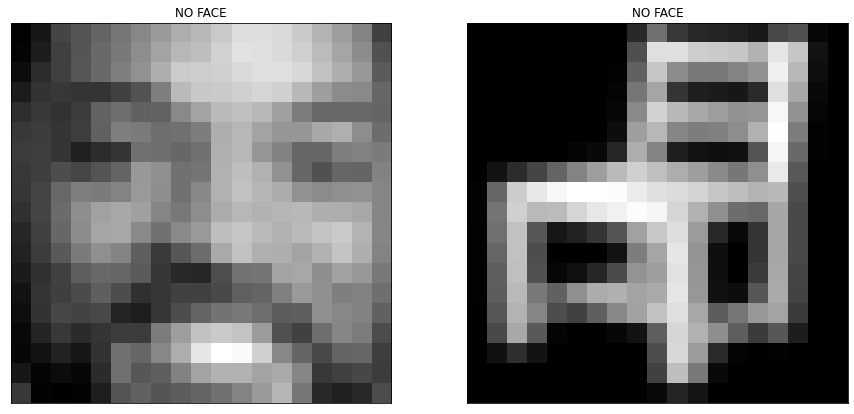

In [34]:
from skimage.color import rgb2gray
from skimage.transform import resize


face = rgb2gray(resize(io.imread("more_faces/face.png"), (19, 19)))
no_face = rgb2gray(resize(io.imread("more_faces/no_face.png") ,(19, 19)))

face_features = extract_feature_image(face, feature_types)
face_prediction = ada.predict(face_features.reshape(1, -1))

no_face_features = extract_feature_image(no_face, feature_types)
no_face_prediction = ada.predict(no_face_features.reshape(1, -1)) 


visualize_n_w_labels([face, no_face], [LABELS[face_prediction[0]], LABELS[no_face_prediction[0]]])

We used diferent images from the internet, a face image and non-face image. They both were classified as no face.

**4.5 (Optional)** Implement the Adaboost training the model with just 1 type of feature. And 2 types? And 3 types? Plot the results comparing the precision. Draw conclusions about the results

In [35]:
scores = []

In [36]:
feature_types = ['type-2-x']

features_faces = [extract_feature_image(i, feature_types) for i in face_images]
non_features_faces = [extract_feature_image(i, feature_types) for i in non_face_images]

X = np.array(features_faces + non_features_faces)
y = np.concatenate((np.ones(len(features_faces)) , np.zeros(len(non_features_faces))))

X_train, X_test, y_train, y_test = train_test_split(X, y)

ada1 = AdaBoostClassifier(n_estimators=50, learning_rate=1.0)
ada1.fit(X_train, y_train)

score = ada1.score(X_test, y_test)
scores.append(score)
print(score)

0.9411764705882353


In [37]:
feature_types = ['type-2-x', 'type-2-y',]

features_faces = [extract_feature_image(i, feature_types) for i in face_images]
non_features_faces = [extract_feature_image(i, feature_types) for i in non_face_images]

X = np.array(features_faces + non_features_faces)
y = np.concatenate((np.ones(len(features_faces)) , np.zeros(len(non_features_faces))))

X_train, X_test, y_train, y_test = train_test_split(X, y)

ada2 = AdaBoostClassifier(n_estimators=50, learning_rate=1.0)
ada2.fit(X_train, y_train)

score = ada2.score(X_test, y_test)
scores.append(score)
print(score)

0.8823529411764706


In [38]:
feature_types = ['type-2-x', 'type-2-y','type-3-x']

features_faces = [extract_feature_image(i, feature_types) for i in face_images]
non_features_faces = [extract_feature_image(i, feature_types) for i in non_face_images]

X = np.array(features_faces + non_features_faces)
y = np.concatenate((np.ones(len(features_faces)) , np.zeros(len(non_features_faces))))

X_train, X_test, y_train, y_test = train_test_split(X, y)

ada3 = AdaBoostClassifier(n_estimators=50, learning_rate=1.0)
ada3.fit(X_train, y_train)

score = ada3.score(X_test, y_test)
scores.append(score)
print(score)

0.8823529411764706


In [39]:
feature_types = ['type-2-x', 'type-2-y','type-3-x','type-3-y',]

features_faces = [extract_feature_image(i, feature_types) for i in face_images]
non_features_faces = [extract_feature_image(i, feature_types) for i in non_face_images]

X = np.array(features_faces + non_features_faces)
y = np.concatenate((np.ones(len(features_faces)) , np.zeros(len(non_features_faces))))

X_train, X_test, y_train, y_test = train_test_split(X, y)

ada4 = AdaBoostClassifier(n_estimators=50, learning_rate=1.0)
ada4.fit(X_train, y_train)

score = ada4.score(X_test, y_test)
scores.append(score)
print(score)

0.9411764705882353


In [40]:
feature_types = ['type-2-x', 'type-2-y',
                 'type-3-x', 'type-3-y',
                 'type-4']

features_faces = [extract_feature_image(i, feature_types) for i in face_images]
non_features_faces = [extract_feature_image(i, feature_types) for i in non_face_images]

X = np.array(features_faces + non_features_faces)
y = np.concatenate((np.ones(len(features_faces)) , np.zeros(len(non_features_faces))))

X_train, X_test, y_train, y_test = train_test_split(X, y)

ada5 = AdaBoostClassifier(n_estimators=50, learning_rate=1.0)
ada5.fit(X_train, y_train)

score = ada5.score(X_test, y_test)
scores.append(score)
print(score)

0.8823529411764706


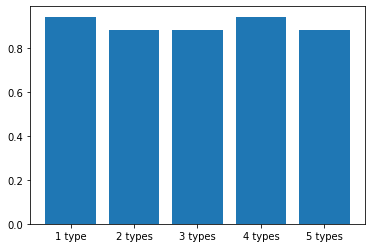

In [41]:
num_types = ["1 type", "2 types", "3 types", "4 types", "5 types"]
plt.bar(num_types, scores)
plt.show()

### 5. Cascade of classifiers

The Cascade Adaboost is implemented in the class ``skimage.feature.Cascade``.

**5.1** Compare the performance of the Cascade classifier  and your Adaboost classifier from point 4 on the folder *another_faces*. Show the detected faces by both classifiers and compare their score.

<img src="notebook_images/cascade.png" width=300, height=300>


[{'r': 151, 'c': 348, 'width': 359, 'height': 359}]


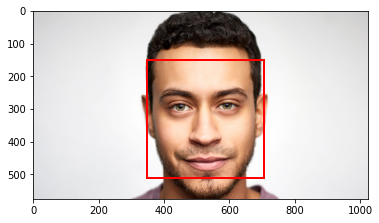

In [48]:
from skimage.feature import Cascade
from skimage import data
from matplotlib import patches

# Load face images
path = "./another_faces/"                       
original_another_faces = [skimage.io.imread(path + f) for f in os.listdir(path)]

# Load the Cascade trained file from the module root.
trained_file = data.lbp_frontal_face_cascade_filename()

# Initialize the dectector cascade
query = original_another_faces[1]
detector = Cascade(trained_file)
detected = detector.detect_multi_scale(img=query, scale_factor=1.2, step_ratio=1, min_size=(50, 50),
                                       max_size=(500, 500))
print(detected)
plt.imshow(query)
img_desc = plt.gca()
plt.set_cmap('gray')

for patch in detected:

    img_desc.add_patch(
        patches.Rectangle(
            (patch['c'], patch['r']),
            patch['width'],
            patch['height'],
            fill=False,
            color='r',
            linewidth=2
        )
    )

plt.show()

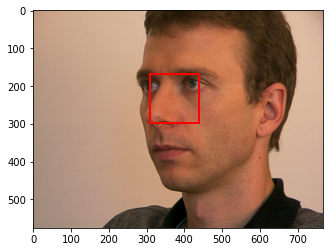

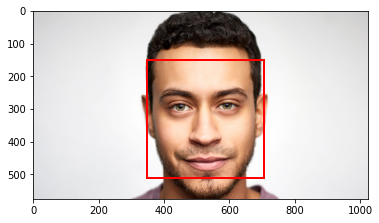

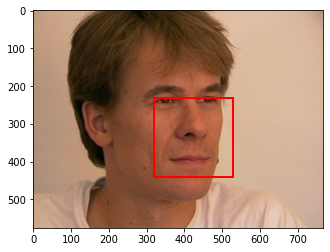

No face was detected...
No face was detected...


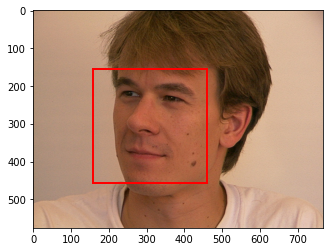

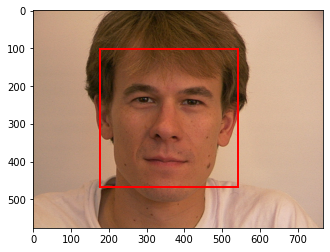

No face was detected...
Cascade detected faces: 


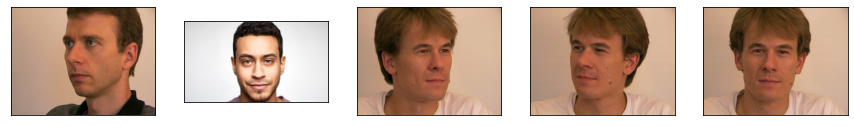

In [60]:
def drawCascade(query):
    detector = Cascade(trained_file)
    detected = detector.detect_multi_scale(img=query, scale_factor=1.2, step_ratio=1, min_size=(50, 50),
                                           max_size=(500, 500))
    if(detected == []):
        print("No face was detected...")
        return None
    
    plt.imshow(query)
    img_desc = plt.gca()
    plt.set_cmap('gray')

    for patch in detected:

        img_desc.add_patch(
            patches.Rectangle(
                (patch['c'], patch['r']),
                patch['width'],
                patch['height'],
                fill=False,
                color='r',
                linewidth=2
            )
        )

    plt.show()
    return query


faces = []
for image in original_another_faces:
    faces.append(drawCascade(image))

index_detected_cascade = [i for i in range(0,len(faces)) if faces[i] is not None]

print("Cascade detected faces: ")
visualize_n([i for i in faces if i is not None])

Adaboost detected faces: 
score:  1.0


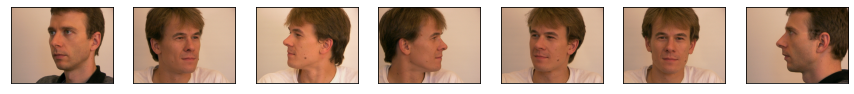

In [61]:
from skimage import img_as_int

another_faces = [img_as_int(normalize(rgb2gray(resize(image, (19,19))))) for image in original_another_faces]

features = [extract_feature_image(image, feature_types) for image in another_faces]
prediction = np.concatenate([ada.predict(feature.reshape(1, -1)) for feature in features])

pred_ind = zip(prediction, [i for i in range(0, len(prediction))])
detected = [i for i in pred_ind if i[0] == 1.]

index_detected_adaboost = [j[1] for j in detected]

print("Adaboost detected faces: ")

visualize_n([original_another_faces[i] for i in index_detected_adaboost])
print("score: ", ada.score(features, prediction))

In [66]:
if len(index_detected_adaboost) >= len(index_detected_cascade):
    common = np.in1d(index_detected_adaboost, index_detected_cascade)
else:
    common = np.in1d(index_detected_cascade, index_detected_adaboost)
    
np.sum(common)

4

In [ ]:
#there is only 4 faces in common. We cannot calculate the cascade score. Aparently 